In [1]:
%matplotlib inline

from importlib.machinery import SourceFileLoader
from sklearn.metrics import r2_score
import algosdk
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import re
import json
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 78)

# Assess Final Dataset

In [2]:
with open('Merged_Data/data_types.json', 'r') as f:
    dtypes_read = json.load(f)
    
folder_name = datetime.datetime.strftime(datetime.datetime.today(),'%d%b%y')
#folder_name='31May20'

files = os.listdir('Merged_Data/'+folder_name)

if len(files) > 1 :
    DF = pd.DataFrame()
    for file in files :
        chunk = pd.read_csv('Merged_Data/'+folder_name+'/'+file,dtype=dtypes_read)
        DF = DF.append(chunk)
else :
    DF = pd.read_csv('Merged_Data/'+folder_name+'/Final_Merged.csv',dtype=dtypes_read)

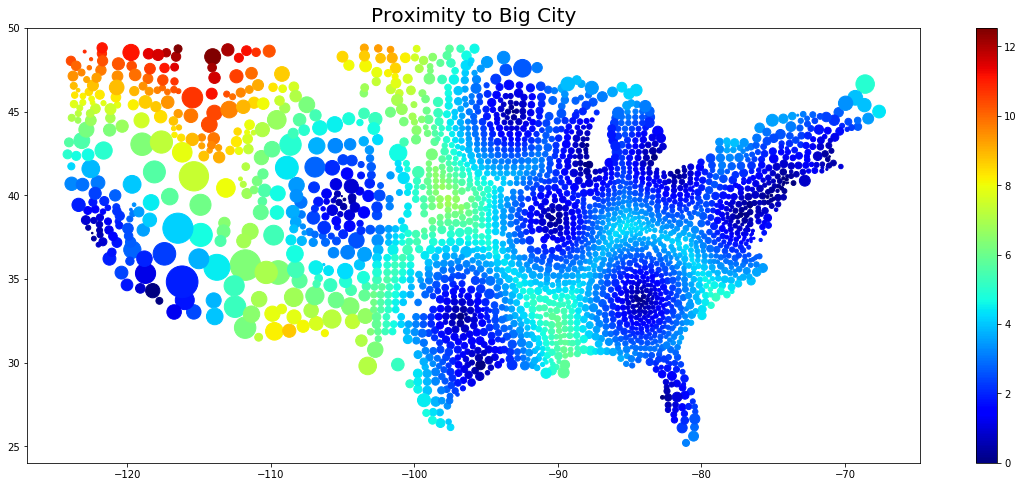

In [4]:
col_plot = 'Proximity'

xlim = [-130,-60]
ylim = [23,50]
to_plot = DF[(DF['Date'] == '05/14/20') & (DF['Long_']>xlim[0]) & (DF['Long_'] < xlim[1]) &
                  (DF['Lat']>ylim[0]) & (DF['Lat'] < ylim[1])]


plt.figure(figsize=(20,8))
plt.scatter(to_plot['Long_'],
            to_plot['Lat'],
            c=to_plot[col_plot],
            s=to_plot['Area (sqmi)']/20,
            cmap=plt.get_cmap('jet'))
plt.colorbar()
#plt.title(col_plot,fontsize=20)
plt.title('Proximity to Big City',fontsize=20)
plt.show()

In [5]:
# Group by state , for visualization purposes.

# Remove territories
DF_Grouped = DF.groupby(['state','Date'],as_index=False)[['Positive','Deaths']].agg('sum').reset_index(drop=True)

# pad data format to match up with datetime format
DF_Grouped['Date'] = DF_Grouped['Date'].apply(lambda x : '/'.join([a.zfill(2) for a in x.split('/')]))

## Generate new features :

DF_Grouped['Cum_Death_Rate'] = DF_Grouped['Deaths']/DF_Grouped['Positive']
DF_Grouped['Cum_Death_Rate'] = DF_Grouped['Cum_Death_Rate'].fillna(0)


In [6]:
def New_Cases_Smoothed(col_new,smooth_num=1) :
    
    new_add = []

    for i,v in DF_Grouped.iterrows() :
        state = v['state']
        date = datetime.datetime.strptime(v['Date'],'%m/%d/%y')
        date_m1 = [datetime.datetime.strftime(date - datetime.timedelta(days=i),'%m/%d/%y') for 
                   i in range(smooth_num+1)]

        old_row = DF_Grouped[(DF_Grouped['state'] == state) & 
                                  (DF_Grouped['Date'].isin(date_m1))]
        new_add.append((max(old_row[col_new].values) - min(old_row[col_new].values)) / smooth_num)
            
    return new_add
    
smoothing_factor = 5 #smooth by 5. Reduced noise in plot

new_pos_cases = New_Cases_Smoothed('Positive',smoothing_factor)    
new_death_cases = New_Cases_Smoothed('Deaths',smoothing_factor) 
DF_Grouped['New_Positive_Cases_Smoothed'] = new_pos_cases
DF_Grouped['New_Deaths_Smoothed'] = new_death_cases

In [7]:
date_mapping = dict(zip(sorted(list(DF_Grouped['Date'].unique())),range(len(set(DF_Grouped['Date'])))))
DF_Grouped['Days_Since_First_Case'] = DF_Grouped['Date'].map(date_mapping)

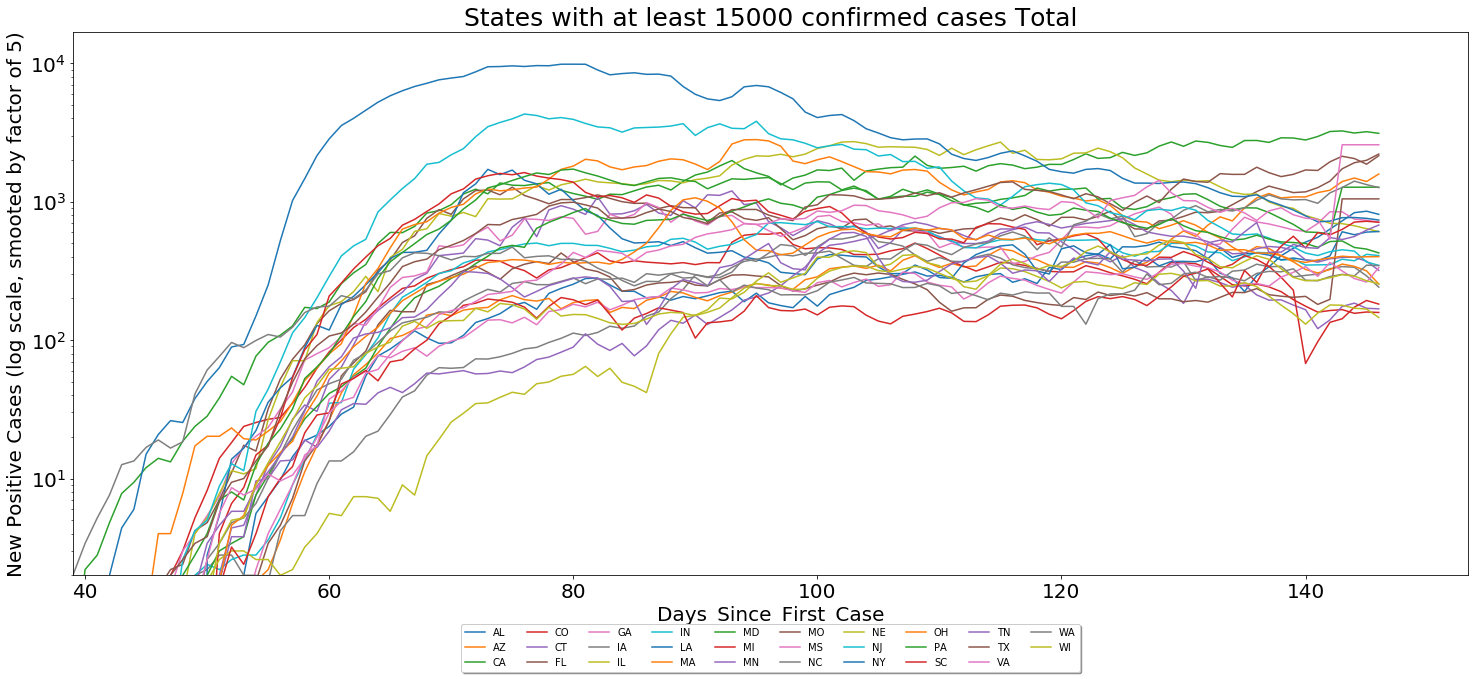

In [8]:
col_plot = 'New_Positive_Cases_Smoothed'

show_for = 15000 #A state needs to have more than this to be plotted
ymin = 2
xmin = min(DF_Grouped[DF_Grouped[col_plot]>=ymin]['Days_Since_First_Case'])

legend_added = []
plt.figure(figsize=(25,10))
for state in DF_Grouped['state'].unique() :
    subbed = DF_Grouped[DF_Grouped['state'] == state]
    subbed = subbed.sort_values('Days_Since_First_Case')
    #dates_xaxis = subbed['Date'].apply(lambda  x : datetime.datetime.strptime(x,'%m/%d/%y'))
    dates_xaxis = subbed['Days_Since_First_Case']
    if max(subbed['Positive'] >= show_for) :
        plt.plot(dates_xaxis,subbed[col_plot])
        legend_added.append(state)
plt.yscale('log')
plt.legend(legend_added,loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=10)
plt.xlabel('Days_Since_First_Case',size=20)
#plt.ylabel('{} (log10, smoothed {} day avg)'.format(col_plot,smoothing_factor),size=20)
plt.ylabel('New Positive Cases (log scale, smooted by factor of {})'.format(smoothing_factor),size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(xmin=xmin)
plt.ylim(ymin=ymin)
plt.title('States with at least {} confirmed cases Total'.format(show_for),size=25)
plt.show()

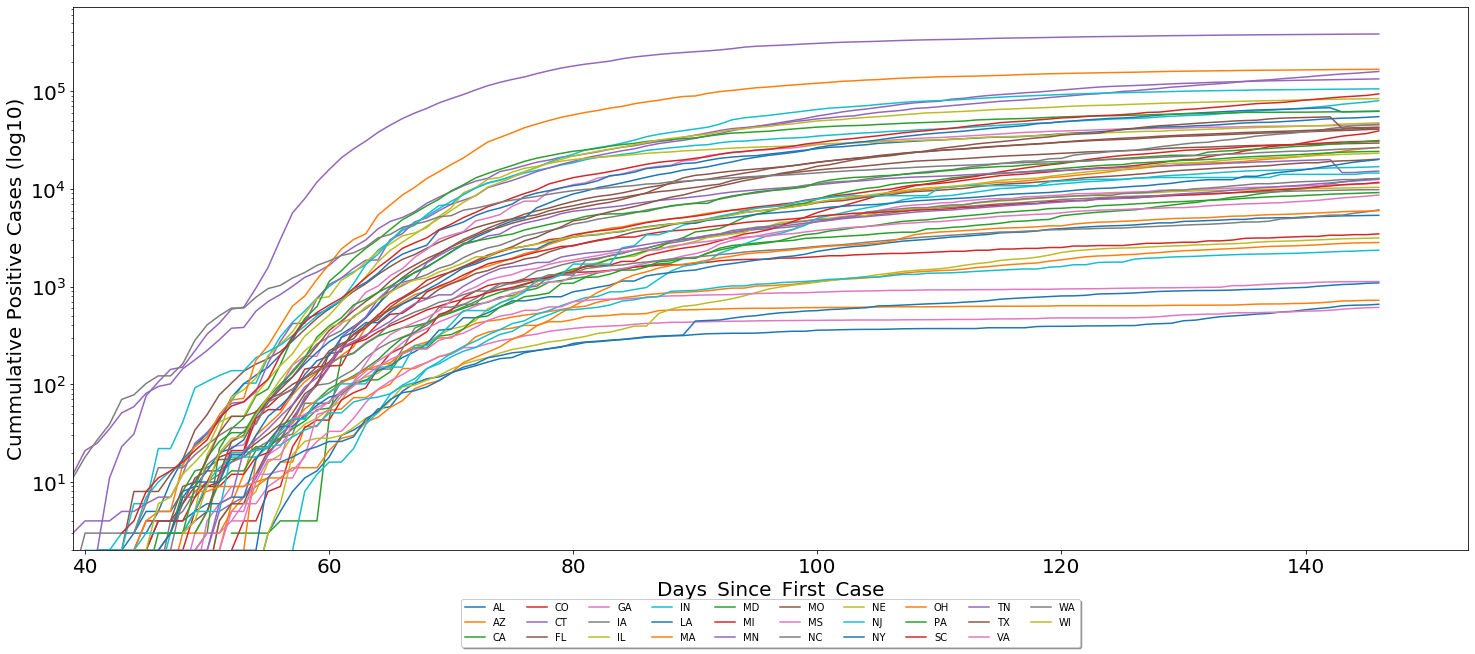

In [9]:
plt.figure(figsize=(25,10))
for state in DF_Grouped['state'].unique() :
    subbed = DF_Grouped[DF_Grouped['state'] == state]
    subbed = subbed.sort_values('Days_Since_First_Case')
    dates_xaxis = subbed['Days_Since_First_Case']
    plt.plot(dates_xaxis,subbed['Positive'])
plt.yscale('log')
plt.legend(legend_added,loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=10)
plt.xlabel('Days_Since_First_Case',size=20)
plt.ylabel('Cummulative Positive Cases (log10)',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(xmin=xmin)
plt.ylim(ymin=ymin)
#plt.title('States with at least {} confirmed cases Total'.format(show_for),size=25)
plt.show()

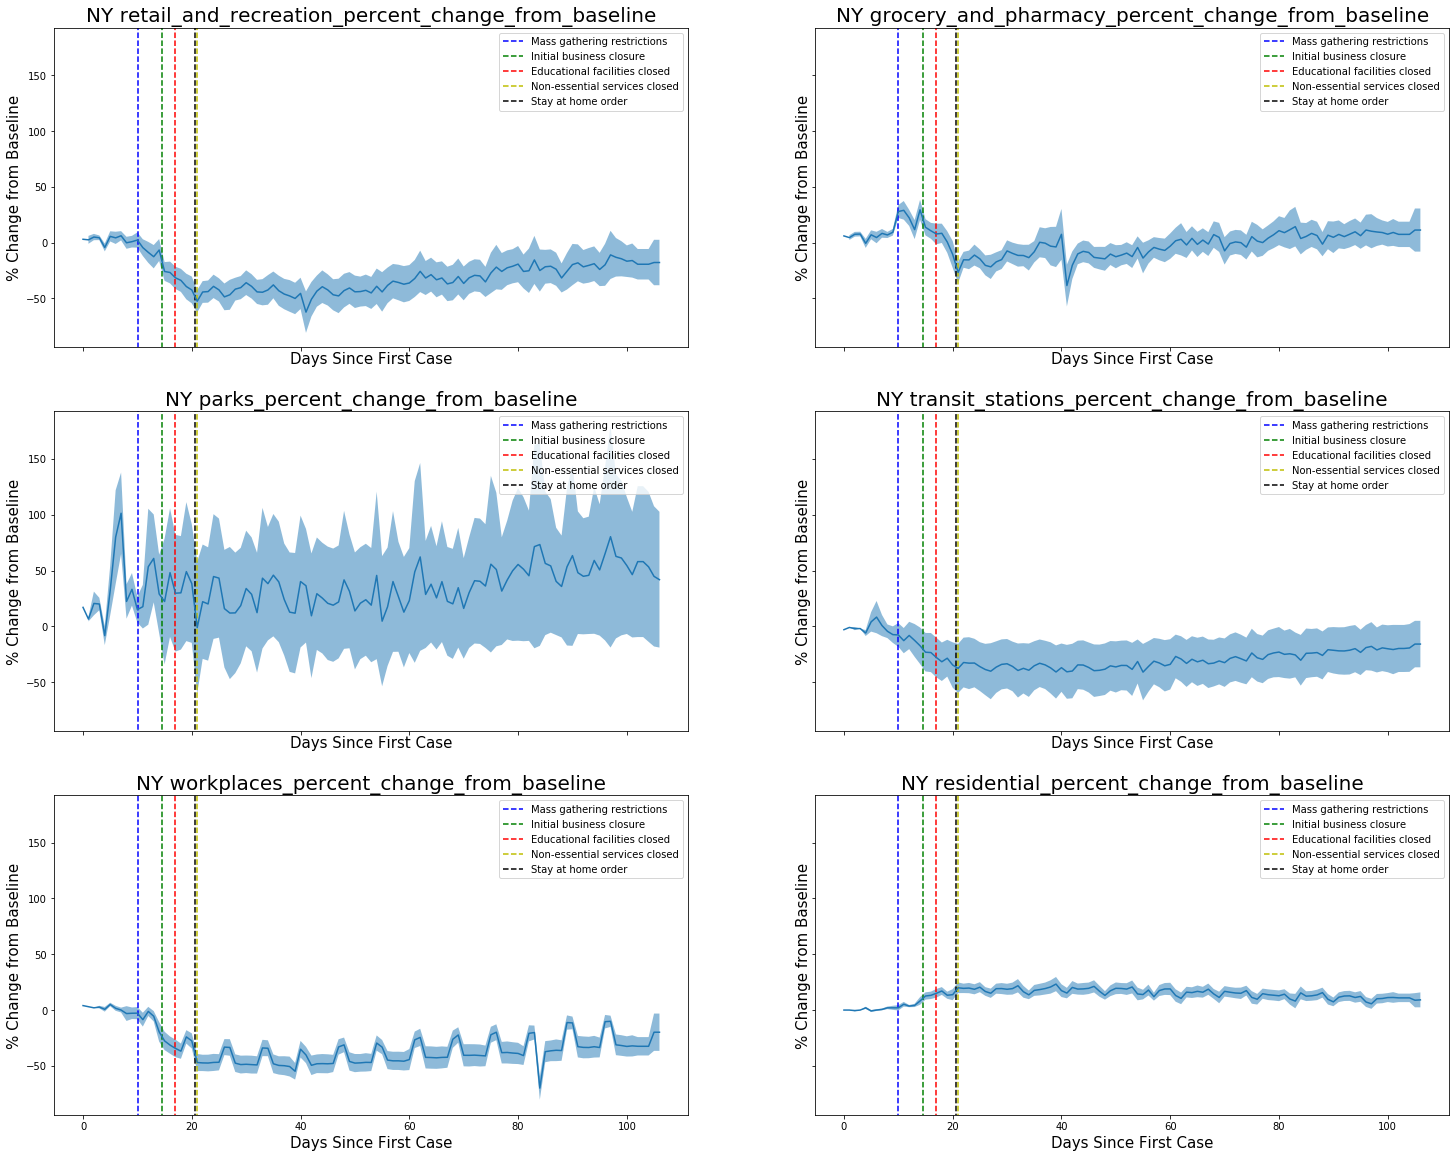

In [10]:
state_assess = 'NY'

orders_columns = ['Mass gathering restrictions', 'Initial business closure',
                  'Educational facilities closed', 'Non-essential services closed',
                  'Stay at home order', 'Travel severely limited']

google_columns = ['retail_and_recreation_percent_change_from_baseline',
                  'grocery_and_pharmacy_percent_change_from_baseline',
                  'parks_percent_change_from_baseline',
                  'transit_stations_percent_change_from_baseline',
                  'workplaces_percent_change_from_baseline',
                  'residential_percent_change_from_baseline']

colors = ['b','g','r','y','k','c']


orders_dates = {}
for order_col in orders_columns :
    try :
        appearance_order = list(DF[DF['state'] == state_assess][order_col]).index(1)
        date_order = DF[DF['state'] == state_assess]['Date'].values[appearance_order]
    except :
        continue
    orders_dates[order_col] = date_order
    
randomness = np.random.random(len(orders_dates))

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(25,20))

i,j = 0,0

for col in google_columns :
    grouped = DF.groupby(['state','Date'])[col].agg(['mean','std'])
    subbed = grouped.iloc[grouped.index.get_level_values('state') == state_assess]
    
    count = 0
    for orders,date in orders_dates.items() :
        index_order = subbed.index.get_level_values('Date').to_list().index(date)
        min_vals = np.array(subbed['mean'].values-subbed['std'].values)
        min_vals = min_vals[~np.isnan(min_vals)]
        max_vals = np.array(subbed['mean'].values+subbed['std'].values)
        max_vals = max_vals[~np.isnan(max_vals)]
        axes[i,j].axvline(x=index_order+randomness[count],ymin=min(min_vals),
               ymax = max(max_vals),label=orders,c=colors[count],linestyle='--')
        count += 1
    axes[i,j].set_title(state_assess+' '+col,fontsize=20)
    axes[i,j].plot(range(subbed.shape[0]),subbed['mean'])
    axes[i,j].fill_between(range(subbed.shape[0]),subbed['mean'].values+subbed['std'].values,
                     subbed['mean'].values-subbed['std'].values,
                     alpha=.5)
    axes[i,j].set_xlabel('Days Since First Case',fontsize=15)
    axes[i,j].set_ylabel('% Change from Baseline',fontsize=15)
    axes[i,j].legend()
    
    if j == 1 :
        j=0
        i+=1
    else :
        j+=1

plt.show()

# Assess Final Model

In [11]:
model = joblib.load('AdaBoost_Model_19MAY2020.pkl')

In [12]:
DF['bias'] = 1

min_value = min(DF['Positive_Cases_PopNormed'])

target_lagged_count = 7
num_lagged_feat_include = 3

for n in range(num_lagged_feat_include) :
    if n == 0 :
        DF['Positive_Cases_PopNormed_Scaled_lagged_1'] = np.log(DF['Positive_Cases_PopNormed']/min_value)
        continue
    new_col = 'Positive_Cases_PopNormed_Scaled_lagged_'+str(n+1)
    DF[new_col] = DF.groupby('FIPS')['Positive_Cases_PopNormed_Scaled_lagged_1'].shift(n)

#DF['Positive_Cases_PopNormed_Scaled_Target'] = DF.groupby('FIPS')['Positive_Cases_PopNormed_Scaled_lagged_1'].shift(-target_lagged_count)                 
DF = DF.dropna()


In [13]:
DF_to_predict = DF.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                         'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                         'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                         'New_Positive_Cases_PopNormed'],axis=1)
#'Positive_Cases_PopNormed_Scaled_Target'

In [14]:
# Make predictions
DF_to_predict['predictions'] = model.predict(DF_to_predict)

DF['predictions'] = DF_to_predict['predictions']

## Curious if this translates well back to the original positive cases count. It does.

In [15]:
# Convert prediction back into the original Positive count value

DF['Positive_Cases_PopNormed_Scaled_Target'] = DF.groupby('FIPS')['Positive_Cases_PopNormed_Scaled_lagged_1'].shift(-target_lagged_count)                 

DF['adjusted_pred'] = np.exp(DF['predictions'])*min_value*DF['population']

DF['positive_shifted'] = DF.groupby('FIPS')['Positive'].shift(-target_lagged_count)

DF = DF.dropna()

In [16]:
num_days_evaluate = 20
dates_evaluate = sorted(DF['Date'].unique())[-num_days_evaluate:]

evaluate_df = DF[DF['Date'].isin(dates_evaluate)]

R2 = r2_score(evaluate_df['Positive_Cases_PopNormed_Scaled_Target'],evaluate_df['predictions']) # eval predictions
R2_transformed = r2_score(evaluate_df['adjusted_pred'],evaluate_df['positive_shifted']) # eval predictions, transformed back to absolute count


print('Dates evaluated :')
print(*dates_evaluate)

print('\nR2 value for the past {} days with associated known values \
(predicting 7 days in future) is ... \n{}'.format(num_days_evaluate,R2))

print('\nR2 value for the past {} days with associated known values TRANSFORMED back into PopNormed \
(predicting 7 days in future) is ... \n{}'.format(num_days_evaluate,R2_transformed))


Dates evaluated :
05/23/20 05/24/20 05/25/20 05/26/20 05/27/20 05/28/20 05/29/20 05/30/20 05/31/20 06/01/20 06/02/20 06/03/20 06/04/20 06/05/20 06/06/20 06/07/20 06/08/20 06/09/20 06/10/20 06/11/20

R2 value for the past 20 days with associated known values (predicting 7 days in future) is ... 
0.95090901767555

R2 value for the past 20 days with associated known values TRANSFORMED back into PopNormed (predicting 7 days in future) is ... 
0.9406373640165936


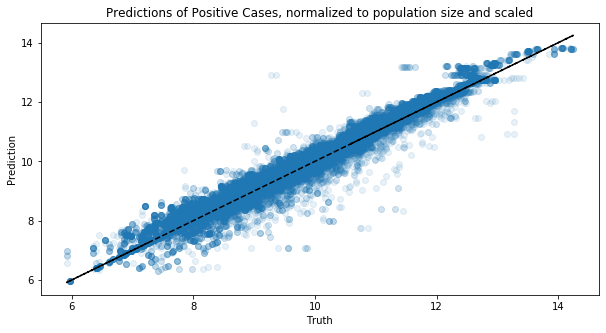

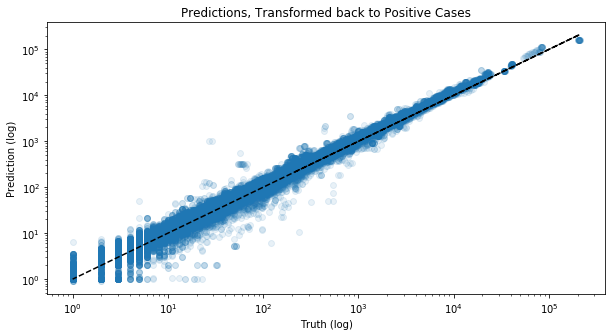

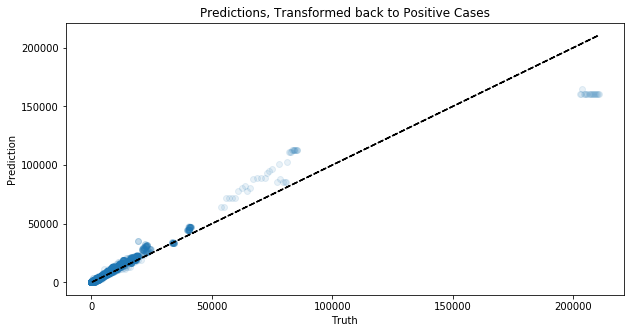

In [92]:
plt.figure(figsize=(10,5))
plt.scatter(evaluate_df['Positive_Cases_PopNormed_Scaled_Target'],evaluate_df['predictions'],alpha=.1)
plt.plot(evaluate_df['Positive_Cases_PopNormed_Scaled_Target'],
         evaluate_df['Positive_Cases_PopNormed_Scaled_Target'],'k--')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.title('Predictions of Positive Cases, normalized to population size and scaled')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(evaluate_df['positive_shifted'],evaluate_df['adjusted_pred'],alpha=.1)
plt.plot(evaluate_df['positive_shifted'],evaluate_df['positive_shifted'],'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Truth (log)')
plt.ylabel('Prediction (log)')
plt.title('Predictions, Transformed back to Positive Cases')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(evaluate_df['positive_shifted'],evaluate_df['adjusted_pred'],alpha=.1)
plt.plot(evaluate_df['positive_shifted'],evaluate_df['positive_shifted'],'k--')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.title('Predictions, Transformed back to Positive Cases')
plt.show()

There are massive outliers in the data (counties such as NYC), when converting predicted values back into absolute positive cases. The $R^2$ is still very high. So there is a bias towards the more common low occuring values, which the model is able to predict quite well.

## The model has held up very well so far, with a very high $R^2$ value for the most recent dates as well (which certainly were not trained on)

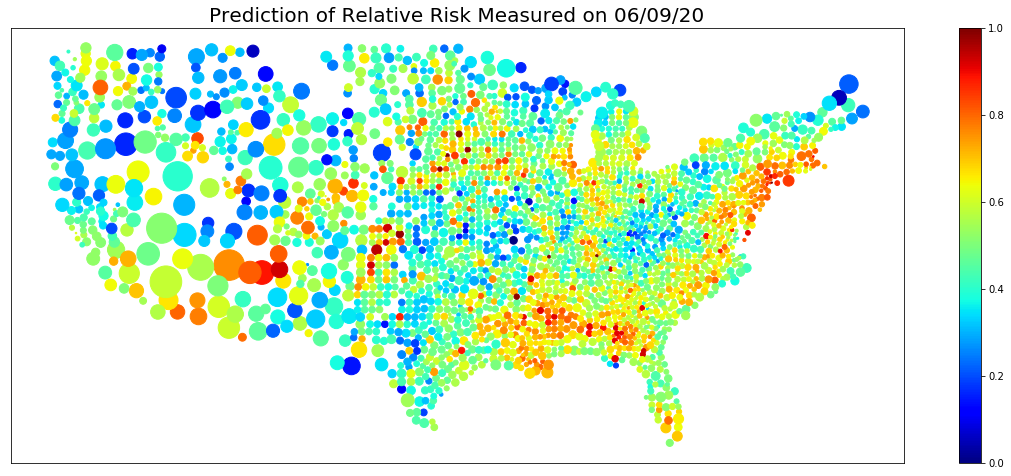

In [27]:
col_plot = 'predictions'
date_predict = '06/09/20'
#date_predict = '05/23/20'

xlim = [-130,-60]
ylim = [23,50]

to_plot = DF[(DF['Date'] == date_predict) & (DF['Long_']>xlim[0]) & (DF['Long_'] < xlim[1]) &
                  (DF['Lat']>ylim[0]) & (DF['Lat'] < ylim[1])]


plt.figure(figsize=(20,8))
plt.scatter(to_plot['Long_'],
            to_plot['Lat'],
            c=(to_plot[col_plot] - min(to_plot[col_plot]))/(max(to_plot[col_plot]) - min(to_plot[col_plot])),
            s=to_plot['Area (sqmi)']/20,
            cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Prediction of Relative Risk Measured on {}'.format(date_predict),fontsize=20)
plt.show()

In [28]:
date_mapping = dict(zip(sorted(list(DF['Date'].unique())),range(len(set(DF['Date'])))))

DF['Days_Since_First_Case'] = DF['Date'].map(date_mapping)


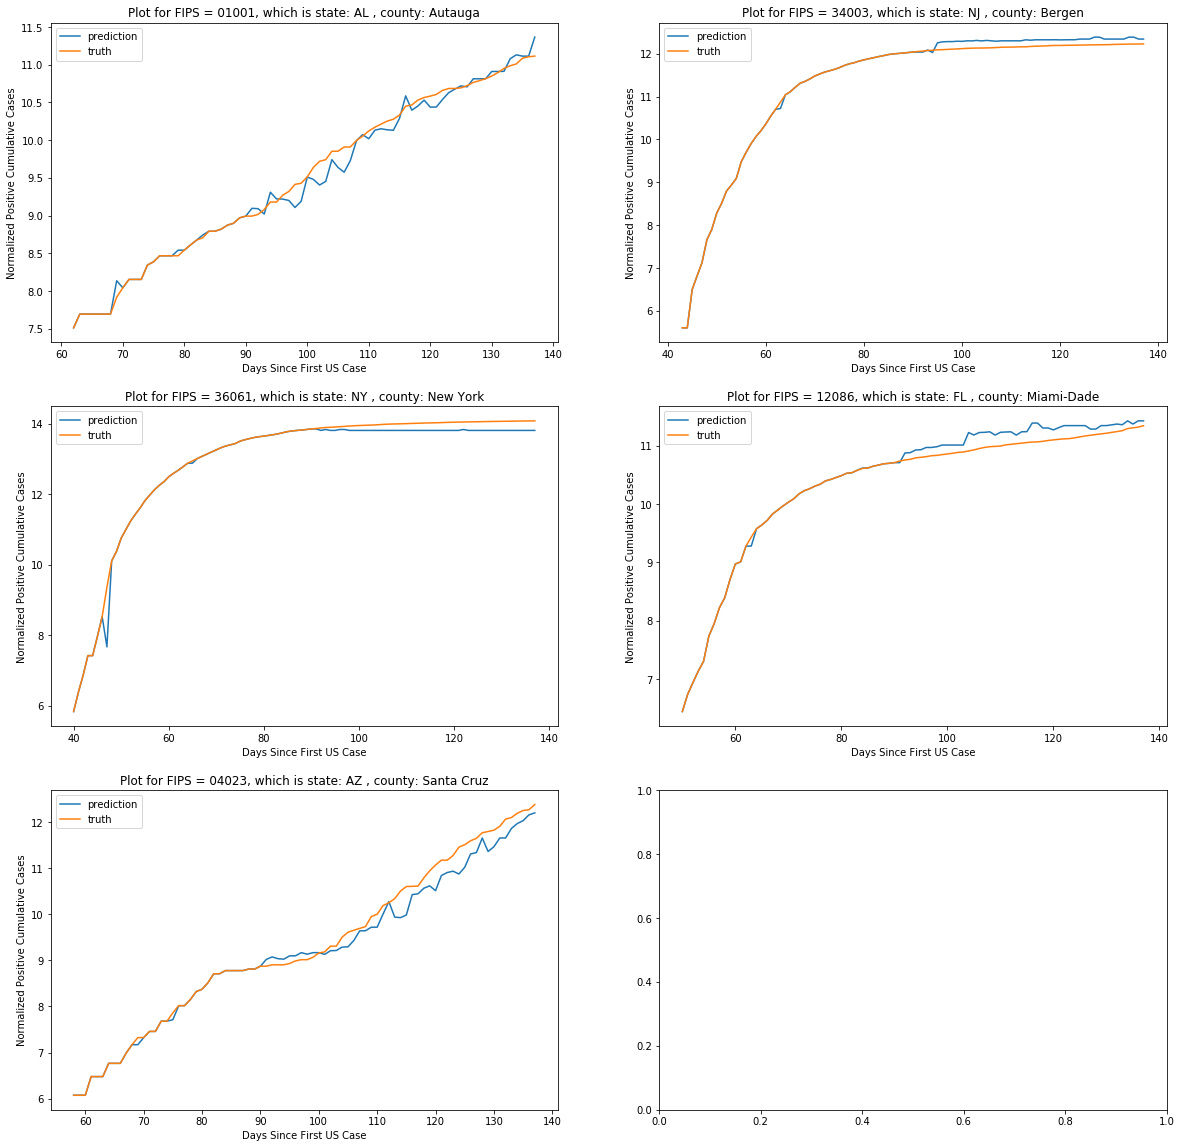

In [94]:
fip_plot = ['01001','34003','36061','12086','04023']

fig,axes = plt.subplots(nrows=int(np.ceil(len(fip_plot)/2)),ncols=2,figsize=(20,20),gridspec_kw={'hspace': .2})
axes = axes.ravel()


for i,fip in enumerate(fip_plot) :
    state_plot = DF[DF['FIPS']==fip]['state'].values[0]
    county_plot = DF[DF['FIPS']==fip]['Admin2'].values[0]
    
    axes[i].plot(DF[DF['FIPS']==fip]['Days_Since_First_Case'],
         DF[DF['FIPS']==fip]['predictions'],label='prediction')
    axes[i].plot(DF[DF['FIPS']==fip]['Days_Since_First_Case'],
         DF[DF['FIPS']==fip]['Positive_Cases_PopNormed_Scaled_Target'],label='truth')
    
    #axes[i].plot(DF[DF['FIPS']==fip]['Days_Since_First_Case'],
    #     DF[DF['FIPS']==fip]['adjusted_pred'],label='prediction')
    #axes[i].plot(DF[DF['FIPS']==fip]['Days_Since_First_Case'],
    #     DF[DF['FIPS']==fip]['positive_shifted'],label='truth')
    
    axes[i].set_xlabel('Days Since First US Case')
    axes[i].set_ylabel('Normalized Positive Cumulative Cases')
    axes[i].set_title('Plot for FIPS = {}, which is state: {} , county: {}'.format(fip,state_plot,county_plot))
    axes[i].legend()
plt.show()